## Introduction
This notebook demonstrates how to scale the CIFAR-10 image classification task using multiple FPGAs.
In the first step, we define the experiment configurations and create a cluster configuration file.

### Define experiment parameters:

BATCH_SIZES => A list of different batch sizes (number of images) we would like to run this experiment for.

PLATFORM => One of the two supported platforms by the driver (alveo/zynq-iodma)

XCLBIN_PATH_ => The path to the .xclbin file

DEVICE_NAME_DEFAULT => Default name for the FPGA device if one not provided via command line args

XRT_ENV_PATH => The path to the setup file that can be used to source the XRT environment

SPAWN_PATH => The path where the dask workers are spawned

In [1]:
BATCH_SIZES = [100,500,2000]

PLATFORM = "alveo"

XCLBIN_PATH_SINGLE = "bitstreams/a_u280.xclbin"

XCLBIN_PATH_DOUBLE = "bitstreams/a_u280_2cu.xclbin"

DEVICE_NAME_DEFAULT = "xilinx_u280_xdma_201920_3"

XRT_ENV_PATH = "/opt/xilinx/xrt/setup.sh"

SPAWN_PATH = "/home/ldierick/octoray/cnv_w1a1_u280"

### Cluster configuration
The cluster configuration is used by OctoRay to set up the cluster. The configuration is identical to the Dask SSH Cluster found at: https://docs.dask.org/en/stable/deploying-ssh.html  
In addition, the **xrt** and **dir** keywords can be used to specify the path to the XRT setup file and the worker's spawn paths.  
The **overlay** keyword is used to specify the bitstream used. By passing a list of bitstreams it is possible to configure different bit streams on different hosts. The list must be the same length as the number of hosts.  
  
In this example a configuration is specified for two hosts. The first host uses a single instance bitstream and therefore a single worker is specified in the worker options. As the second host uses a double bitstream, the number of workers is specifed to 2.

In [2]:
import json
cluster_config = {
    "scheduler":"10.1.212.130",
    "hosts":["10.1.212.130"], 
    "connect_options":{"port":22,"xrt":XRT_ENV_PATH,"dir":SPAWN_PATH},
    "worker_options":{"nthreads":1,"n_workers":2,"preload":"pynqimport.py","nanny":"0","memory_limit":0},
    "scheduler_options":{"port":8786},

    "worker_class":"distributed.Worker",
    "overlay": XCLBIN_PATH_DOUBLE,
}

with open("cluster_config.json","w") as f:
    json.dump(cluster_config,f)



### Download dataset
Download a numpy-array formatted CIFAR-10 dataset to the current directory:

In [ ]:
!wget https://raw.githubusercontent.com/modestyachts/CIFAR-10.1/master/datasets/cifar10.1_v4_data.npy

### Define the worker method

Here, we define the Python method which will be executed on each of the Dask workers. This function calls the driver using the data partition it receives, and returns the output data (along with some performance statistics) to the caller (the OctoRay client)


In [3]:
def run_on_worker(ibuf_normal, kernel, index):
    import numpy as np
    import time
    from driver import FINNAccelDriver
    from pynq.ps import Clocks
    import os
    
    t0_total = time.time()

    batch_size = len(ibuf_normal) 
    device_name = kernel["device"]
    xclbin_path = kernel["path_to_bitstream"]


    finnDriver = FINNAccelDriver(batch_size, xclbin_path, platform=PLATFORM, device_name=device_name, kernel=kernel)
    ibuf_folded = finnDriver.fold_input(ibuf_normal)
    ibuf_packed = ibuf_folded
    finnDriver.copy_input_data_to_device(ibuf_packed)
    
    t0 = time.time()
    finnDriver.execute()
    t1 = time.time()
    
    obuf_packed = np.empty_like(finnDriver.obuf_packed_device)
    finnDriver.copy_output_data_from_device(obuf_packed)
    obuf_folded = finnDriver.unpack_output(obuf_packed)
    obuf_normal = finnDriver.unfold_output(obuf_folded)

    if PLATFORM != "alveo":
        fclk_mhz = Clocks.fclk0_mhz
    else:
        fclk_mhz = finnDriver.fclk_mhz
    runtime = t1-t0
    
    t1_total = time.time()


    return {
        'data': obuf_normal,
        'runtime': runtime,
        'index': index,
        'fclk_mhz': fclk_mhz,
        'throughput': batch_size/runtime,
        'bandwidth_in': np.prod(finnDriver.ishape_packed)*0.000001 / runtime,
        'bandwidth_out': np.prod(finnDriver.oshape_packed)*0.000001 / runtime,
        'N': batch_size

    }



### Create the cluster

Create the octoray object by specifying the cluster configuration and whether automatic deployment is wished.
If the ssh_cluster is set to true, the create_cluster method spawns Dask worker processes on the hosts according to the configuration. If ssh_cluster is set to False, a client is created that is attached to the existing cluster.


In [4]:
import time
import numpy as np
import json
from octoray import Octoray

# Initialiaze octoray with automatic cluster deployment
octoray = Octoray(ssh_cluster=True, cluster_config=cluster_config)

# create the cluster
octoray.create_cluster()


Initializing OctoRay with client ip: 10.1.212.130


distributed.deploy.ssh - INFO - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at:   tcp://10.1.212.130:8786
distributed.deploy.ssh - INFO - distributed.diskutils - INFO - Found stale lock file and directory '/home/ldierick/octoray/cnv_w1a1_u280/dask-worker-space/worker-k6io_j8a', purging
distributed.deploy.ssh - INFO - distributed.diskutils - INFO - Found stale lock file and directory '/home/ldierick/octoray/cnv_w1a1_u280/dask-worker-space/worker-trnwewyb', purging
distributed.deploy.ssh - INFO - distributed.diskutils - INFO - Found stale lock file and directory '/home/ldierick/octoray/cnv_w1a1_u280/dask-worker-space/worker-3ugtlsxj', purging
distributed.deploy.ssh - INFO - distributed.utils - INFO - Reload module pynqimport f

Waiting until workers are set up on remote machines...
Current amount of workers: 2


### Run the example
Here we run the example by pursuing the following steps:

1. Create kernels such that the amount of workers and the bitstreams match with the cluster configurations
2. Divide the input data over the kernels
3. Submit the *run_on_worker* defined above to the scheduler, which will run it on all the workers.
4. Collect and merge the results

In [6]:
import time
import numpy as np
import json


# load dataset
full_cifar = np.load('cifar10.1_v4_data.npy')

execution_times = []

T = time.time()


for BATCH_SIZE in BATCH_SIZES:
    
    t0 = time.time()
    cnn_kernels = []
    
    
    # A single instance CNN kernel
    # cnn_kernels.append(octoray.create_kernel(XCLBIN_PATH_SINGLE,1,int(BATCH_SIZE/octoray.num_of_workers),[[{"idma0":["DDR0"]},{"odma0":["DDR0"]}]],host="10.1.212.126",device=DEVICE_NAME_DEFAULT))

    # A double instance CNN kernel
    cnn_kernels.append(octoray.create_kernel(XCLBIN_PATH_DOUBLE,2,int(BATCH_SIZE/(octoray.num_of_workers)), [[{"idma0":["HBM0"]},{"odma0":["HBM0"]}],[{"idma1":["HBM1"]},{"odma1":["HBM1"]}]],host="10.1.212.130", device=DEVICE_NAME_DEFAULT))
    
    
    # In the case of multiple instances, subdivide the kernels over the number of instances
    kernels_split = octoray.split_kernels(cnn_kernels)
    
    
    # Divide the data set over the kernels based on batch size per instance
    data_split = octoray.split_data(full_cifar[:BATCH_SIZE],kernels_split)
    
    # Launch the tasks after scattering the data and kernels to the correct workers
    results = octoray.execute_hybrid(run_on_worker,data_split,kernels_split)

    # Reorder the response based on the original input order
    results.sort(key = lambda result: result['index'])  

    # Concatenate the result where each is an ndarray of the shape (BATCH_SIZE/num_of_workers, 1)
    merged_result = np.concatenate([r['data'] for r in results]) # FINAL RESULTS (CLASS LABELS)

    t1 = time.time()
    max_fpga_runtime = max([r['runtime'] for r in results])
   
    def avg(li):
        return sum(li)/len(li)

   
    print("TOTAL EXECUTION TIME:", t1-t0)
    print("Maximum FPGA runtime[s]:", max_fpga_runtime) # Shown in the plot
    print("Average throughput per node[images/s]:", avg([r['throughput'] for r in results]))
    print("Total throughput[image/s]:", BATCH_SIZE/ np.max([r['runtime'] for r in results]))
    print([r["runtime"] for r in results])
    print("Average DRAM_in_bandwidth[Mb/s]:", avg([r['bandwidth_in'] for r in results])) 
    print("Average DRAM_out_bandwidth[Mb/s]:", avg([r['bandwidth_out'] for r in results]))    
    print("**************************")   
    execution_times.append(max_fpga_runtime)

    
print(f"total time for all batches: {time.time()-T}")



TOTAL EXECUTION TIME: 0.5182743072509766
Maximum FPGA runtime[s]: 0.01836419105529785
Average throughput per node[images/s]: 2757.7706404375767
Total throughput[image/s]: 5445.380071405388
[0.01836419105529785, 0.017902851104736328]
Average DRAM_in_bandwidth[Mb/s]: 8.471871407424235
Average DRAM_out_bandwidth[Mb/s]: 0.0027577706404375768
**************************
TOTAL EXECUTION TIME: 0.25197458267211914
Maximum FPGA runtime[s]: 0.08391451835632324
Average throughput per node[images/s]: 2980.9255757270957
Total throughput[image/s]: 5958.444495586184
[0.08381867408752441, 0.08391451835632324]
Average DRAM_in_bandwidth[Mb/s]: 9.157403368633638
Average DRAM_out_bandwidth[Mb/s]: 0.002980925575727096
**************************
TOTAL EXECUTION TIME: 0.5220537185668945
Maximum FPGA runtime[s]: 0.33107662200927734
Average throughput per node[images/s]: 3020.769741580498
Total throughput[image/s]: 6040.8976866507855
[0.33107662200927734, 0.3310062885284424]
Average DRAM_in_bandwidth[Mb/s]: 9.2

### Shutdown OctoRay
When using an OpenSSH version < 7.9, OctoRay needs to be forcefully shut down with the fshutdown function. This is because the signal channel isn't implemented in these versions of OpenSSH as explained in: https://github.com/ronf/asyncssh/issues/112

In [ ]:
await octoray.fshutdown()

### Generate a performance plot
Plot the execution times for different batch sizes. Here, we plot the maximum FPGA execution times from all the workers. This time includes the data buffering time to/from the FPGA and the actual inference time. To plot the total end-to-end time instead, replace the *execution_times* variable below with the *end_to_end_times* variable.

<Figure size 3600x3600 with 0 Axes>

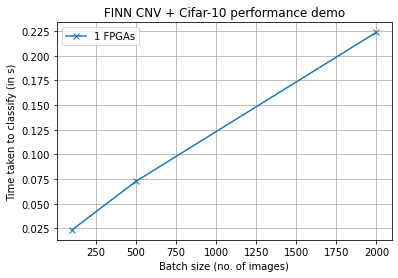

In [7]:
import numpy as np
import matplotlib.pyplot as plt
f = plt.figure(figsize=(50,50))
x = BATCH_SIZES[:3]
f = plt.figure()

y2 = execution_times
plt.plot(x, y2, label = "1 FPGAs", marker='x')

plt.xlabel('Batch size (no. of images)')
plt.ylabel('Time taken to classify (in s)')
plt.title('FINN CNV + Cifar-10 performance demo')

plt.legend()
plt.grid()

# f.savefig("cnv-1-vs-2.png", bbox_inches='tight', dpi=150)

### Measure scaling benefits
To measure the benefits of scaling, run this notebook again after creating or destroying one or more Dask workers. Then compare the plots above to see the speedup.